Importing gempy



In [1]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

No module named 'osgeo'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pasha\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [2]:
#define resolution and mesh size
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[-100, 898, 0, 2500, -1228, 100]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [3]:
geo_data = gp.create_data('foresets', extent=extent, resolution=reso,
                          path_o="2_orientation_data_all.csv",
                          path_i="1_point_data_all.csv")

gp.map_stack_to_surfaces(geo_data, {"Strat_Series1": ('topo'),
                                    "Strat_Series2":('easterncreekvolcanics'),
                                    "Strat_Series3":('silicadolomitealteration'),
                                    "Strat_Series4":('spearsiltstone', 'dolomiticurquhartshale','nativebeesiltstone'),
                                    "Host_Rock": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,topo,Strat_Series1,1,#015482,1
1,easterncreekvolcanics,Strat_Series2,1,#9f0052,2
3,silicadolomitealteration,Strat_Series3,1,#728f02,3
2,spearsiltstone,Strat_Series4,1,#ffbe00,4
4,dolomiticurquhartshale,Strat_Series4,2,#443988,5
5,nativebeesiltstone,Strat_Series4,3,#ff3f20,6
6,basement,Host_Rock,1,#5DA629,7


In [4]:
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Erosion,True,False,False
Strat_Series4,4,Erosion,True,False,False
Host_Rock,5,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


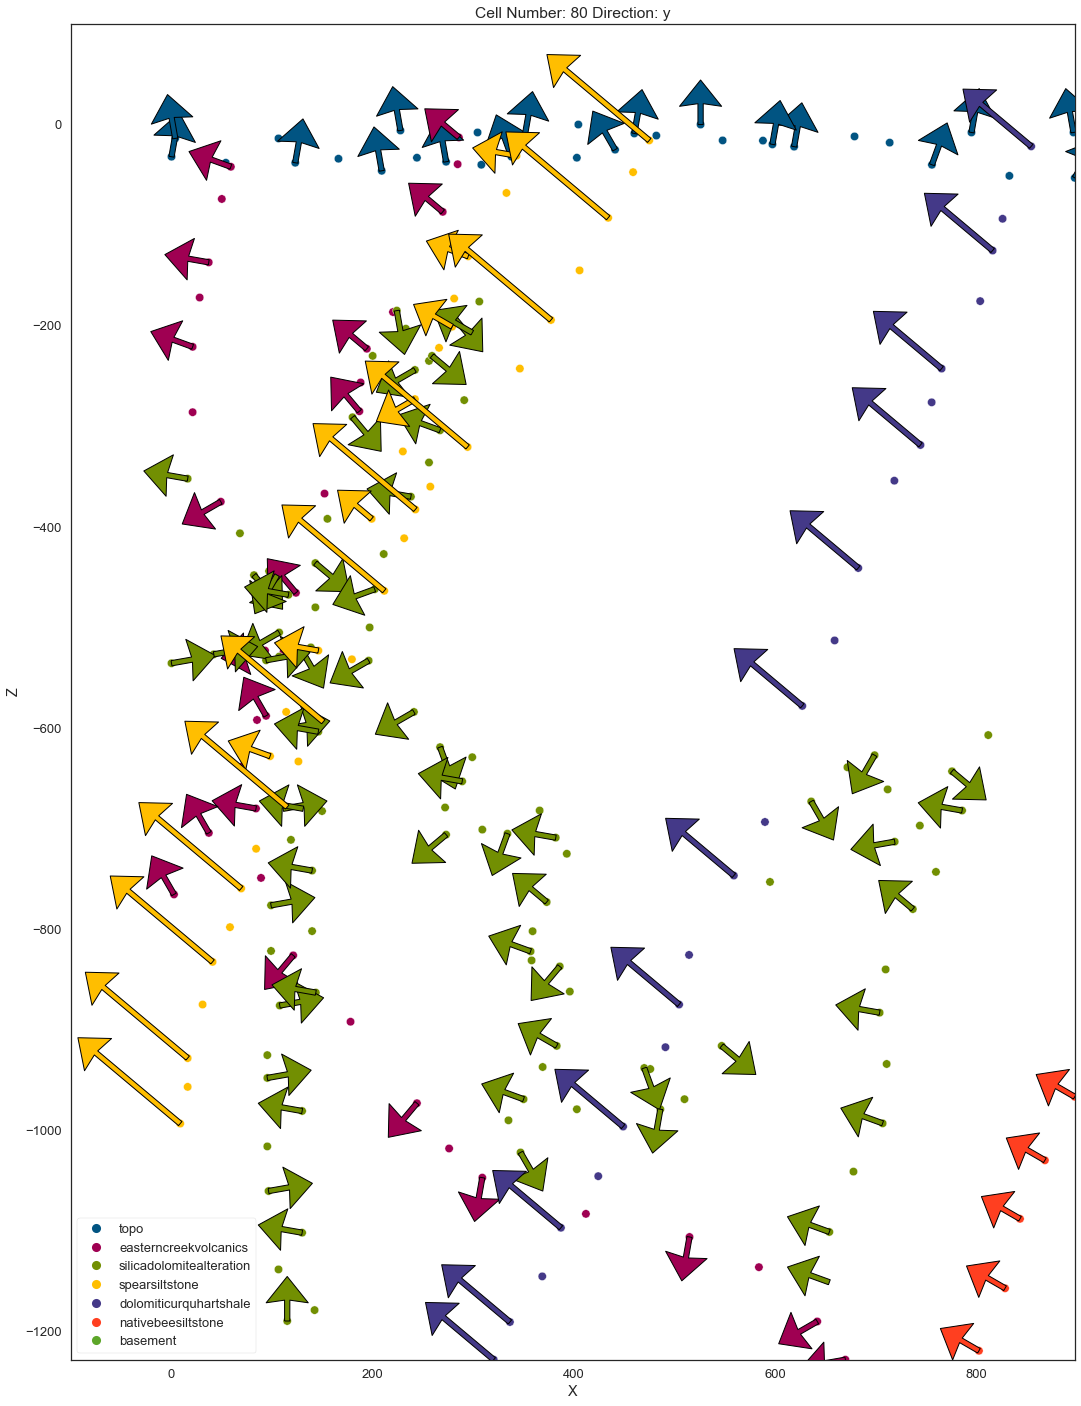

In [5]:
gp.plot_2d(geo_data, cell_number=80, figsize=(20,20))

In [6]:
geo_data.set_topography()

[-165.6  100. ]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  -90.02      ,    25.        , -1214.72      ],
       [  -90.02      ,    25.        , -1188.16      ],
       [  -90.02      ,    25.        , -1161.6       ],
       ...,
       [  898.        ,  2397.95918367,  -116.80296236],
       [  898.        ,  2448.97959184,  -112.31097675],
       [  898.        ,  2500.        ,  -111.76843328]])

In [7]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range                     3001.6
$C_o$                   214514.0
drift equations  [3, 3, 3, 3, 3]


In [8]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 22.6 s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


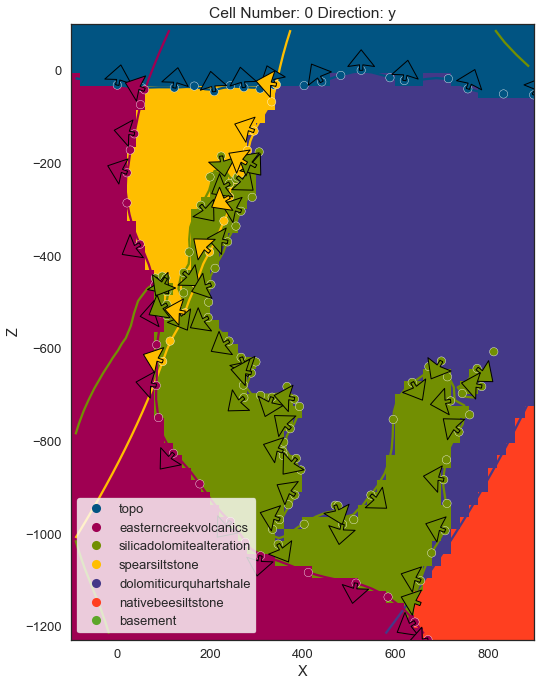

In [9]:
gp.plot_2d(geo_data, direction='y', cell_number=0, show_data=True,  figsize=(10,10))

In [18]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .8})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [10]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [11]:
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(7, 4)

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [33]:
#load csv file and introduce it to pandas dataframe
df=pd.read_csv('3_kriging_data_all_Pb-Zn ratio.csv')
#df=pd.read_csv('3_kriging_data_all_Cu.csv')
df

,X,Y,Z,grade_value,grade,section
0,327.00,0,-220.00,0.86,Pb/Zn,Mount Isa
1,328.00,0,-236.00,0.87,Pb/Zn,Mount Isa
2,347.00,0,-145.00,0.87,Pb/Zn,Mount Isa
3,345.00,0,-137.00,0.87,Pb/Zn,Mount Isa
4,278.00,0,-370.00,0.85,Pb/Zn,Mount Isa
...,...,...,...,...,...,...
223,236.25,2000,-1106.68,0.54,Pb/Zn,Hilton
224,293.15,2000,-1039.61,0.53,Pb/Zn,Hilton
225,368.60,2000,-905.46,0.55,Pb/Zn,Hilton
226,401.99,2000,-822.61,0.53,Pb/Zn,Hilton


In [34]:
# define kriging points coordinates and grade values (Cu)
n=len(df.iloc[:,2])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,3]

# define kriging points coordinates and grade values(Lenses)

In [35]:
# This is to extract smaller domains from gempy by 

domain_x, domain_y, domain_z = extract_domain(sol, (3,5))

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)

In [36]:
# Define kriging function (Cu)
#(CondSRF - conditional spatial random fields)
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field= krige

In [37]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [38]:
# 3D plotting example of Cu krige
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)


#a = pc_Cu.plot('3d_field')
#p = pvqt.BackgroundPlotter(pc)


gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': 1})

gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="viridis")

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028953504AC0

### Pb/Zn ore volume

In [19]:
#density of Pb ore (Galena) is 19.3 g/cm3
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Horizon I:
    if 0.6>grade.active_scalars[index]>0.5:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Horizon II:
    elif 0.9>grade.active_scalars[index]>0.8:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,3):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print("Horizon{} = ".format(i),volume)
    print("Average ore grade=", ore_avrg_grade)

100%|██████████████████████████████████| 56296/56296 [00:27<00:00, 2056.70it/s]

Horizon1 =  195355705.6
Average ore grade= 0.5714840759699418
Horizon2 =  54180062.71999999
Average ore grade= 0.8287378169364487


### Cu ore volume

In [26]:
#density of Pb ore (Galena) is 19.3 g/cm3
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Horizon I:
    if 2.3>grade.active_scalars[index]>2.1:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Horizon II:
    elif 3.4>grade.active_scalars[index]>3.2:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,3):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print("Horizon{} = ".format(i),volume)
    print("Average ore grade=", ore_avrg_grade)

100%|██████████████████████████████████| 56296/56296 [00:29<00:00, 1933.43it/s]

Horizon1 =  14048646.399999999
Average ore grade= 2.2454611260257513
Horizon2 =  19350022.4
Average ore grade= 3.2456122839423815


### Extract kriged data

In [64]:
%%time
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])
grade

Wall time: 70.9 ms


,X,Y,Z,grade
0,-90.02,1225.0,-1214.72,0.68
1,-90.02,1225.0,-1188.16,0.68
2,-90.02,1225.0,-1161.60,0.68
3,-90.02,1275.0,-1214.72,0.68
4,-90.02,1275.0,-1188.16,0.68
...,...,...,...,...
56291,888.02,1375.0,-125.76,0.68
56292,888.02,1425.0,-125.76,0.68
56293,888.02,1475.0,-125.76,0.67
56294,888.02,1525.0,-99.20,0.67


In [65]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict
        
boreholes=krige_boreholes(100)

100%|████████████████████████████████████████| 100/100 [07:57<00:00,  4.77s/it]


In [66]:
drill_all = pd.concat(boreholes.values(), ignore_index=True)
drill_all

,X,Y,Z,grade,borehole
0,548.7,75.0,-1108.48,0.71,1
1,548.7,75.0,-1081.92,0.71,1
2,548.7,75.0,-1055.36,0.72,1
3,548.7,75.0,-1028.80,0.72,1
4,548.7,75.0,-1002.24,0.73,1
...,...,...,...,...,...
3001,-50.1,2075.0,-1188.16,0.63,100
3002,-50.1,2075.0,-1161.60,0.63,100
3003,-50.1,2075.0,-1135.04,0.62,100
3004,-50.1,2075.0,-1108.48,0.62,100


In [67]:
list_tempo=[]
for index in range(0,len(drill_all),15):
    list_tempo.append(drill_all.iloc[index])
br=pd.DataFrame(list_tempo)

br.to_csv('3_kriging_Pb-Zn_100.csv')
br

,X,Y,Z,grade,borehole
0,548.70,75.0,-1108.48,0.71,1.0
15,548.70,75.0,-710.08,0.80,1.0
30,548.70,75.0,-311.68,0.84,1.0
45,588.62,2375.0,-577.28,0.64,2.0
60,588.62,2375.0,-178.88,0.64,2.0
...,...,...,...,...,...
2940,329.14,2175.0,-789.76,0.58,98.0
2955,329.14,2175.0,-391.36,0.59,98.0
2970,488.82,75.0,-816.32,0.78,99.0
2985,488.82,75.0,-417.92,0.84,99.0


In [68]:
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values
kriged

PolyData (0x14605331e20)
  N Cells:	3006
  N Points:	3006
  X Bounds:	-5.010e+01, 8.681e+02
  Y Bounds:	2.500e+01, 2.475e+03
  Z Bounds:	-1.215e+03, -1.952e+01
  N Arrays:	1

In [69]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001466D31CF40

### Extract orientation and point data from the solution with the same boreholes

In [12]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing

def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

 # get coordinates
x = sol.grid.regular_grid.values[:, 0]
y = sol.grid.regular_grid.values[:, 1]
z = sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation 
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation']
    
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]

dict_spec['series_1']=dict_spec['series_1'][dict_spec['series_1'].formation==2]

dict_spec['series_2']=dict_spec['series_2'][dict_spec['series_2'].formation==3]

dict_spec['series_3'] = dict_spec['series_3'].loc[(dict_spec['series_3'].formation > 3) & (dict_spec['series_3'].formation < 7)]

orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2'],dict_spec['series_3']],ignore_index=True)
orientations

,G_x,G_y,G_z,X,Y,Z,formation
0,0.11,-8.36e-03,0.99,-90.02,25.0,7.04,1.0
1,0.11,-1.23e-02,0.99,-90.02,25.0,33.60,1.0
2,0.10,-1.50e-02,0.99,-90.02,25.0,60.16,1.0
3,0.09,-1.58e-02,1.00,-90.02,25.0,86.72,1.0
4,0.11,-1.70e-02,0.99,-90.02,75.0,7.04,1.0
...,...,...,...,...,...,...,...
124362,-0.69,4.80e-01,0.54,888.02,2475.0,-125.76,5.0
124363,-0.68,4.78e-01,0.55,888.02,2475.0,-99.20,5.0
124364,-0.67,4.75e-01,0.56,888.02,2475.0,-72.64,5.0
124365,-0.67,4.70e-01,0.58,888.02,2475.0,-46.08,5.0


In [13]:
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [14]:
# if you want to join all files in the same folder
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
ideal = pd.concat(dfs, ignore_index=True)
#df.drop(df.columns[[0]], axis=1, inplace=True)
ideal

,X,Y,Z,formation
0,-90.02,25.0,7.04,1.0
1,-90.02,25.0,33.60,1.0
2,-90.02,25.0,60.16,1.0
3,-90.02,25.0,86.72,1.0
4,-90.02,75.0,7.04,1.0
...,...,...,...,...
124995,888.02,2425.0,-1161.60,7.0
124996,888.02,2425.0,-1135.04,7.0
124997,888.02,2475.0,-1214.72,7.0
124998,888.02,2475.0,-1188.16,7.0


In [15]:
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same= df_same[df_same.formation != unit_count]
df_same

,G_x,G_y,G_z,X,Y,Z,formation
0,0.11,-8.36e-03,0.99,-90.02,25.0,7.04,1.0
1,0.11,-1.23e-02,0.99,-90.02,25.0,33.60,1.0
2,0.10,-1.50e-02,0.99,-90.02,25.0,60.16,1.0
3,0.09,-1.58e-02,1.00,-90.02,25.0,86.72,1.0
4,0.11,-1.70e-02,0.99,-90.02,75.0,7.04,1.0
...,...,...,...,...,...,...,...
91602,-0.70,4.78e-01,0.52,888.02,2475.0,-178.88,6.0
91603,-0.70,4.80e-01,0.53,888.02,2475.0,-152.32,6.0
91604,-0.68,4.78e-01,0.55,888.02,2475.0,-99.20,5.0
91605,-0.67,4.75e-01,0.56,888.02,2475.0,-72.64,5.0


In [16]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)
# boreholes_dict.to_csv('test100')

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

  1%|▍                                         | 1/100 [00:08<14:28,  8.78s/it]


KeyboardInterrupt: 

In [219]:
unit=('topo','easterncreekvolcanics', 'silicadolomitealteration','spearsiltstone','dolomiticurquhartshale',
      'nativebeesiltstone')
   
for index in range(1,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
#df[df['formation']=='metaturbitic-greywacke&shale'] #- just for checking the dataset

In [220]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='Paired', point_size=10)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001DBFADE5340

In [210]:
#picking lowermost boundary for each formation through the borehole data 

dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']
df_b=df_b[df_b.formation !='easterncreekvolcanics']
df_b

,X,Y,Z,G_x,G_y,G_z,formation
0,817.18,1075.0,-1214.72,-6.67e-01,-3.76e-01,0.64,nativebeesiltstone
1,817.18,1075.0,7.04,5.28e-02,-9.39e-02,0.99,topo
2,817.18,1075.0,-391.36,-7.53e-01,-4.33e-01,0.50,dolomiticurquhartshale
3,134.70,625.0,7.04,3.65e-03,-3.51e-02,1.00,topo
5,134.70,625.0,-603.84,-8.21e-01,1.44e-01,0.55,spearsiltstone
...,...,...,...,...,...,...,...
161,278.38,2025.0,-311.68,-6.13e-01,-9.41e-03,0.79,spearsiltstone
162,278.38,2025.0,-1214.72,-7.15e-01,-2.27e-02,0.70,dolomiticurquhartshale
163,26.94,1725.0,7.04,-4.73e-02,-1.40e-02,1.00,topo
165,26.94,1725.0,-869.44,-8.50e-01,2.13e-02,0.53,spearsiltstone


In [221]:
#picking lowermost boundary for each formation through the borehole data 

dict_all1=[]
list_temp1=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp1.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for df in list_temp1:
    if(not df.empty):
        list_temp2.append(df.iloc[-1])
df_f=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_f['borehole']
df_f1=df_f[df_f['formation']=='silicadolomitealteration']
df_f2=df_f[df_f['formation']=='easterncreekvolcanics']
df_f=pd.concat([df_f1,df_f2])
df_f

,X,Y,Z,G_x,G_y,G_z,formation
22,422.06,325.0,-1002.24,-0.25,-9.34e-01,-0.25,silicadolomitealteration
73,475.94,75.0,-1002.24,0.06,5.55e-02,-1.00,silicadolomitealteration
100,170.62,275.0,-656.96,-0.05,-8.84e-01,-0.46,silicadolomitealteration
128,134.70,1975.0,-550.72,-0.59,7.87e-01,-0.18,silicadolomitealteration
228,350.22,125.0,-736.64,-0.69,-4.83e-01,-0.54,silicadolomitealteration
252,350.22,125.0,-736.64,-0.69,-4.83e-01,-0.54,silicadolomitealteration
308,619.62,25.0,-710.08,0.61,-5.94e-01,-0.52,silicadolomitealteration
329,332.26,225.0,-736.64,-0.58,-5.92e-01,-0.56,silicadolomitealteration
1,206.54,475.0,-949.12,-0.70,-2.37e-01,-0.68,easterncreekvolcanics
8,170.62,1775.0,-46.08,-0.80,9.19e-03,0.60,easterncreekvolcanics


In [222]:
joined=pd.concat([df_b,df_f])
#joined[joined['formation']=='pipe']
t = pd.CategoricalDtype(categories=['topo','easterncreekvolcanics', 'silicadolomitealteration','spearsiltstone','dolomiticurquhartshale',
      'nativebeesiltstone'], ordered=True)
joined['formation']=pd.Series(joined.formation, dtype=t)
joined.sort_values(by=['formation'],inplace=True)
joined

,X,Y,Z,G_x,G_y,G_z,formation
117,817.18,1825.0,7.04,-1.54e-02,2.08e-02,1.00,topo
32,547.78,75.0,7.04,5.23e-02,1.21e-01,0.99,topo
90,350.22,1725.0,7.04,-6.62e-04,-9.74e-03,1.00,topo
157,655.54,575.0,7.04,6.49e-02,2.49e-03,1.00,topo
36,260.42,2225.0,7.04,-1.33e-02,7.08e-03,1.00,topo
...,...,...,...,...,...,...,...
65,799.22,2225.0,-1214.72,-7.79e-01,2.08e-01,0.59,nativebeesiltstone
62,799.22,325.0,-1214.72,-6.86e-01,-1.63e-01,0.71,nativebeesiltstone
46,871.06,1125.0,-1214.72,-6.77e-01,-3.58e-01,0.64,nativebeesiltstone
40,727.38,525.0,-1214.72,-6.68e-01,-2.86e-01,0.69,nativebeesiltstone


In [223]:
joined.to_csv(r'data_all_test100.csv', index = False)